# Predictive Maintenance using ML and AI
### Step 1. Preparing the data (cleanup the excel sheet)


In [55]:
import pandas as pd
import numpy as np

# Load Excel (header at row 2)
df = pd.read_excel(
    "dataset/faults/LocoFault_Data_38616_04042025_135209PART1.XLSX",
    sheet_name="SHEET",
    header=2,
)

In [56]:
# Clean column names and keep relevant columns
df.rename(columns=lambda x: str(x).strip(), inplace=True)
df = df[["Date /Time", "Fault Code", "Fault-Description"]].copy()
df.columns = ["DateTime", "FaultCode", "FaultDescription"]

In [57]:
# Convert types and drop invalid rows
df["DateTime"] = pd.to_datetime(df["DateTime"], errors="coerce")
df["FaultCode"] = pd.to_numeric(df["FaultCode"], errors="coerce")
df.dropna(subset=["DateTime", "FaultCode"], inplace=True)
df.set_index("DateTime", inplace=True)

In [58]:
# Keep only ASCU-related faults, skipping NODISP, Recovered, and MCC
df = df[df["FaultDescription"].str.contains("ASCU", case=False, na=False)]
df = df[~df["FaultDescription"].str.contains("NODISP", case=False, na=False)]
df = df[~df["FaultDescription"].str.contains("Recovered", case=False, na=False)]
df = df[~df["FaultDescription"].str.contains("MCC", case=False, na=False)]

# Now the data is ready for analysis!
### Step 2. Identifying the top 10 faults that occured over time


In [59]:
# Top 10 most frequent faults (only ASCU-related)
df_reset = df.reset_index()
df_reset["Week"] = df_reset["DateTime"].dt.to_period("W").dt.start_time
faults_by_week = (
    df_reset.groupby(["Week", "FaultDescription"]).size().reset_index(name="Count")
)
top_faults = df["FaultDescription"].value_counts().nlargest(10).index
top_faults_weekly = faults_by_week[faults_by_week["FaultDescription"].isin(top_faults)]
top10 = top_faults_weekly.pivot(
    index="Week", columns="FaultDescription", values="Count"
).fillna(0)

print("Top 10 ASCU-related faults by week: (can be printed to see the output)")
# print(top10.head(10))

Top 10 ASCU-related faults by week: (can be printed to see the output)


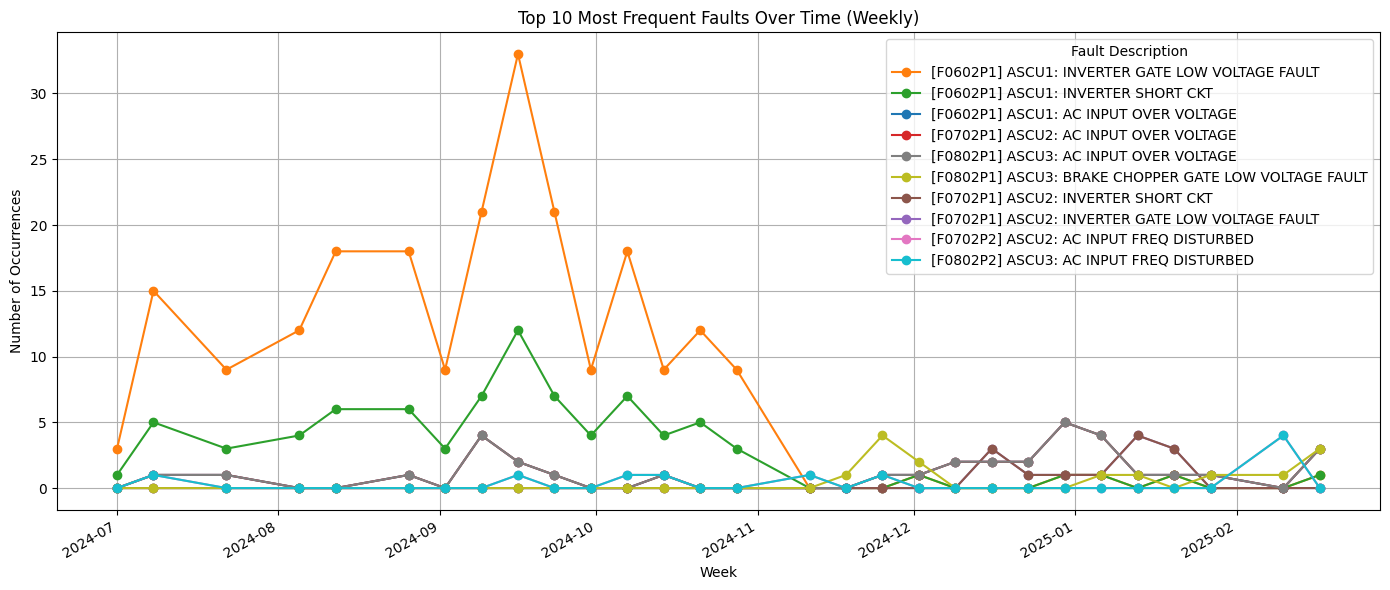

In [60]:
import matplotlib.pyplot as plt

totals = top10.sum().sort_values(ascending=False)
ax = top10.plot(marker="o", figsize=(14, 6))
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    [dict(zip(labels, handles))[l] for l in totals.index],
    totals.index,
    title="Fault Description",
    loc="upper right",
)

plt.title("Top 10 Most Frequent Faults Over Time (Weekly)")
plt.xlabel("Week")
plt.ylabel("Number of Occurrences")
plt.grid(True)
plt.tight_layout()
plt.show()

## Interactive Plot

In [61]:
import plotly.express as px

sorted_columns = top10.sum().sort_values(ascending=False).index
fig = px.line(
    top10[sorted_columns],
    markers=True,
    title="Top 10 Most Frequent Faults Over Time (Weekly)",
)
fig.update_layout(xaxis_title="Week", yaxis_title="Occurrences")
fig.show()

## Step 3.1 Forecasting for each fault from top 10 (using Prophet library)

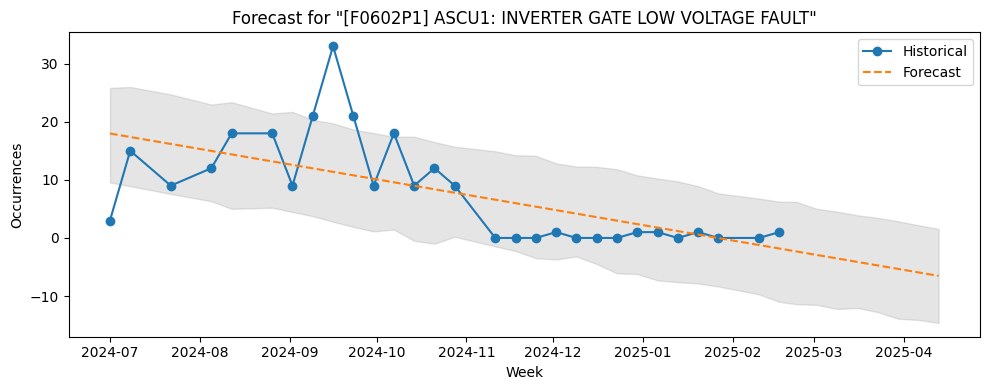

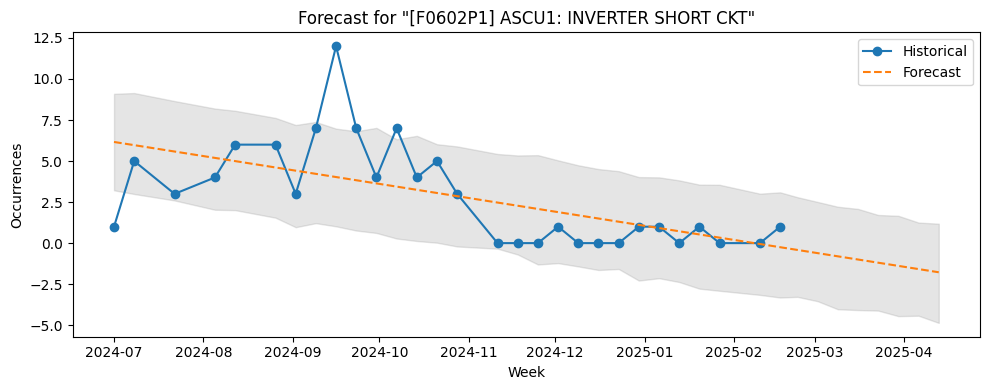

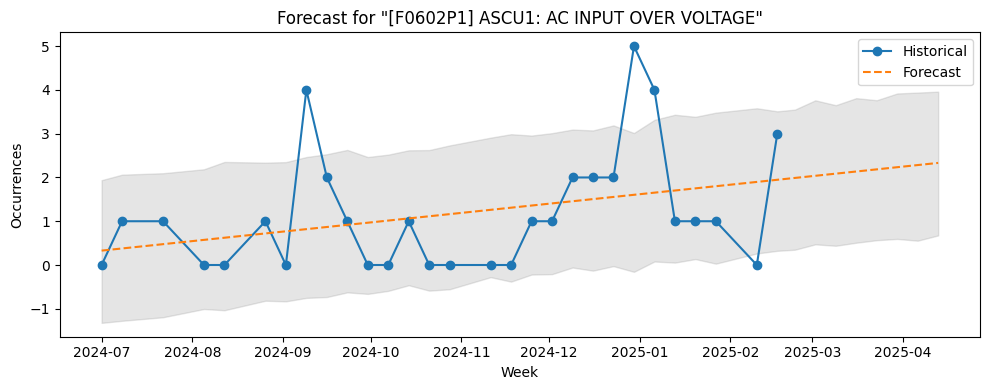

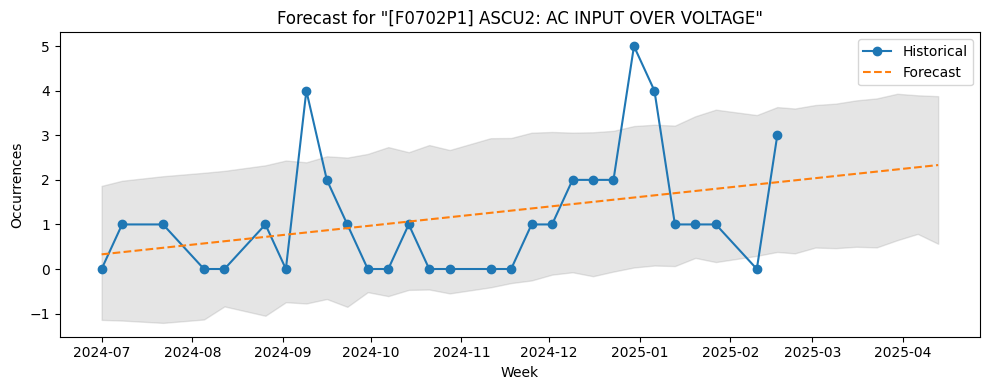

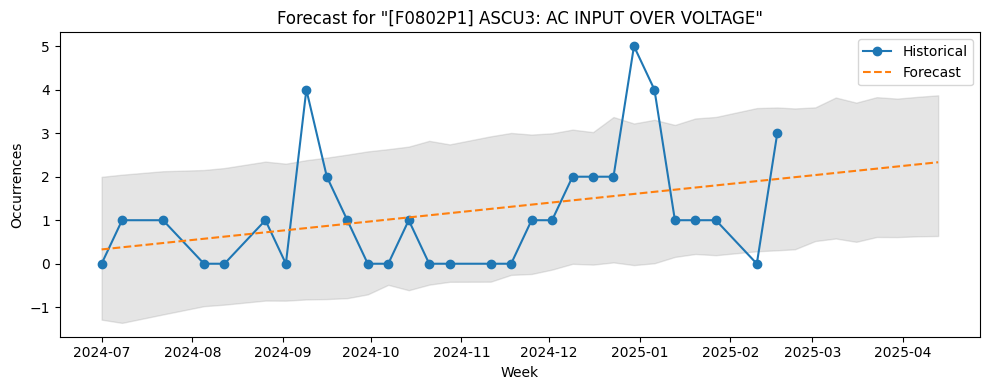

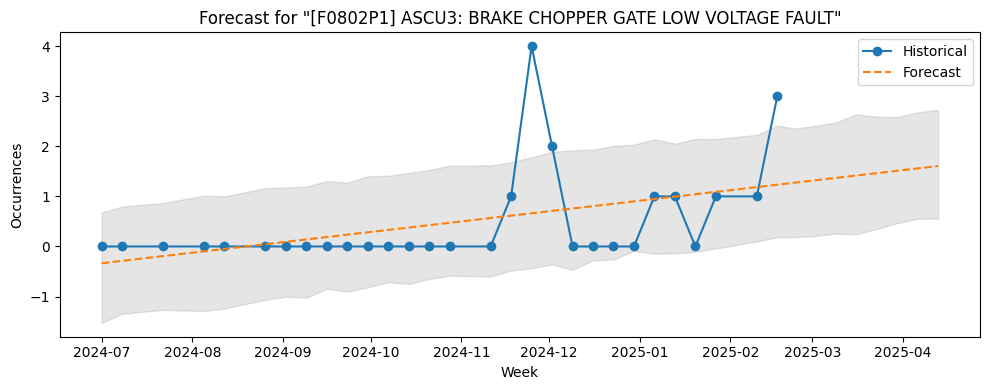

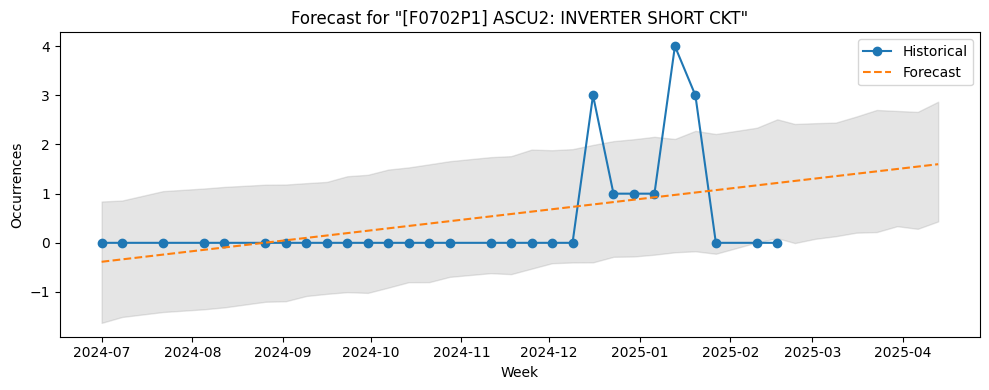

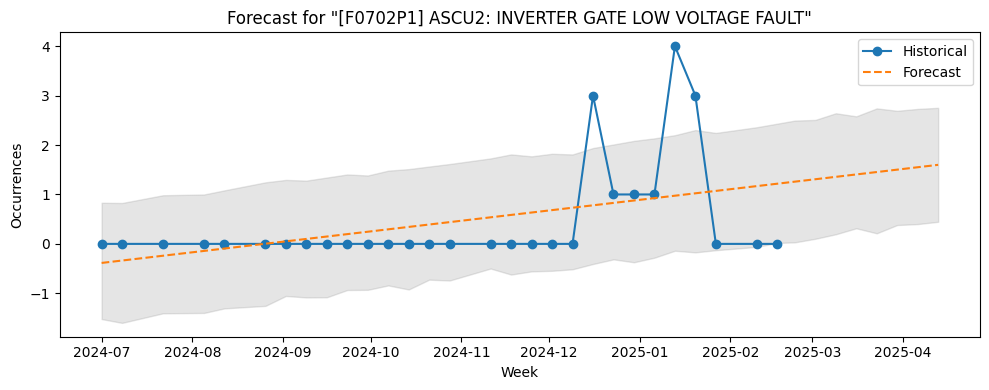

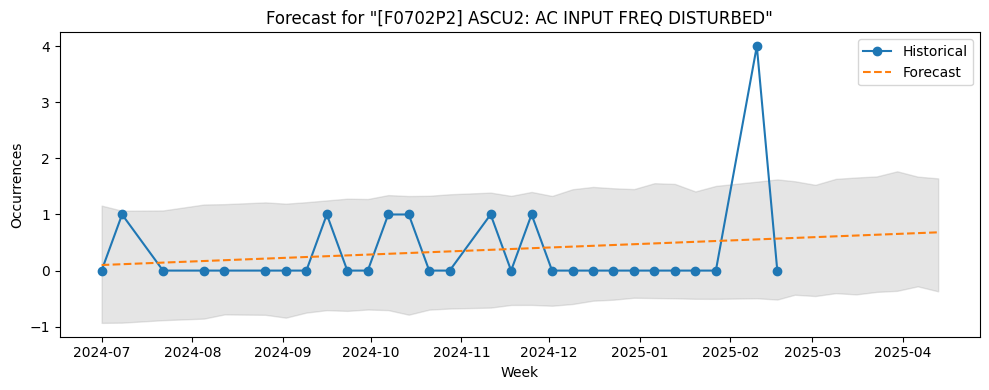

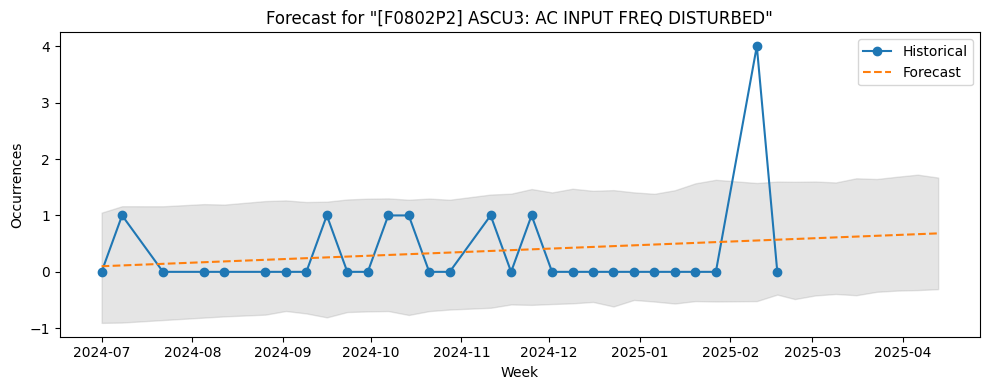

In [62]:
from prophet import Prophet
import matplotlib.pyplot as plt
# Suppress annoying cmdstanpy warnings
import logging
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

for fault in top10.sum().sort_values(ascending=False).index:
    ts = top10[fault].reset_index().rename(columns={"Week": "ds", fault: "y"})
    m = Prophet(
        weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False
    )
    m.fit(ts)
    future = m.make_future_dataframe(periods=8, freq="W")
    forecast = m.predict(future)
    plt.figure(figsize=(10, 4))
    plt.plot(ts["ds"], ts["y"], marker="o", label="Historical")
    plt.plot(forecast["ds"], forecast["yhat"], linestyle="--", label="Forecast")
    plt.fill_between(
        forecast["ds"],
        forecast["yhat_lower"],
        forecast["yhat_upper"],
        alpha=0.2,
        color="gray",
    )
    plt.title(f'Forecast for "{fault}"')
    plt.xlabel("Week")
    plt.ylabel("Occurrences")
    plt.legend()
    plt.tight_layout()
    plt.show()

### 3.2 Forecast using scikit-learn method


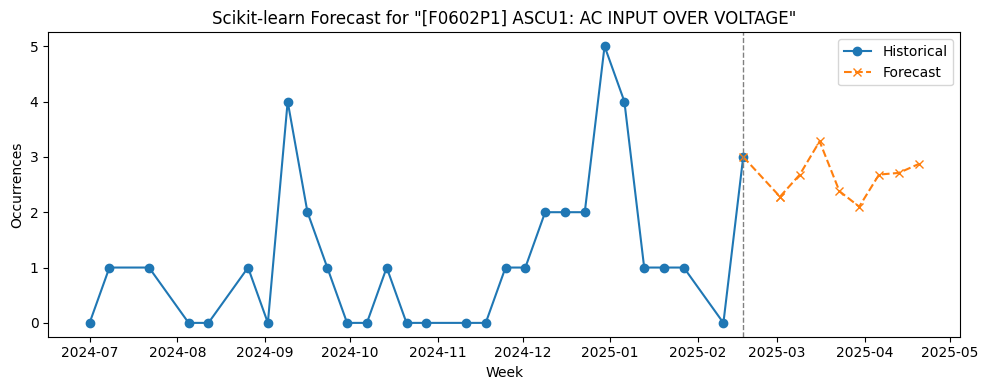

MAE (last 4 weeks) for "[F0602P1] ASCU1: AC INPUT OVER VOLTAGE": 0.3975000000000001


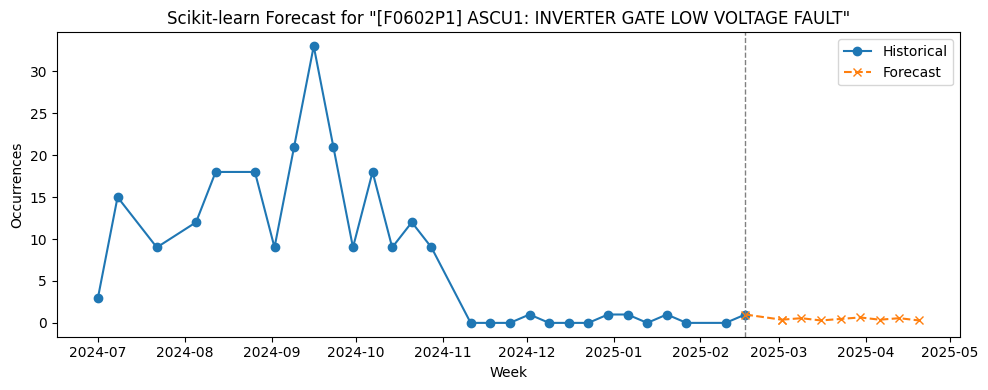

MAE (last 4 weeks) for "[F0602P1] ASCU1: INVERTER GATE LOW VOLTAGE FAULT": 0.27249999999999996


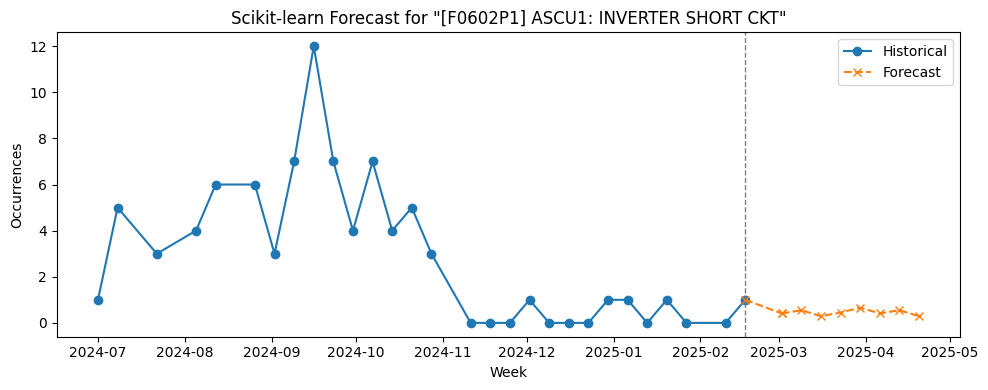

MAE (last 4 weeks) for "[F0602P1] ASCU1: INVERTER SHORT CKT": 0.27


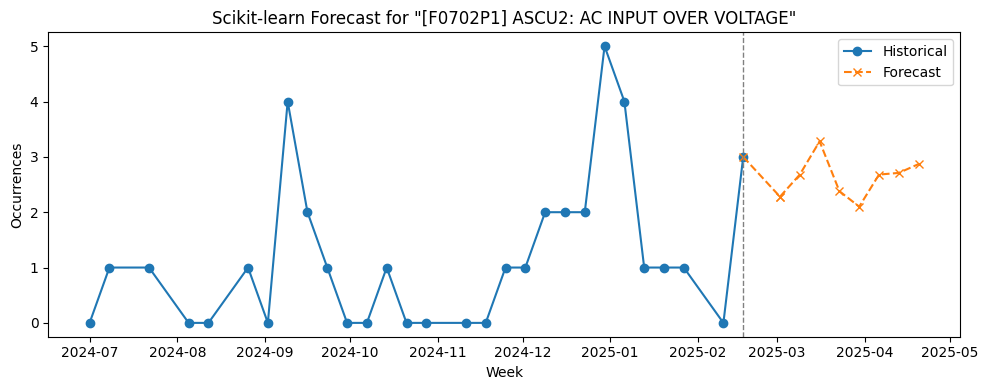

MAE (last 4 weeks) for "[F0702P1] ASCU2: AC INPUT OVER VOLTAGE": 0.3975000000000001


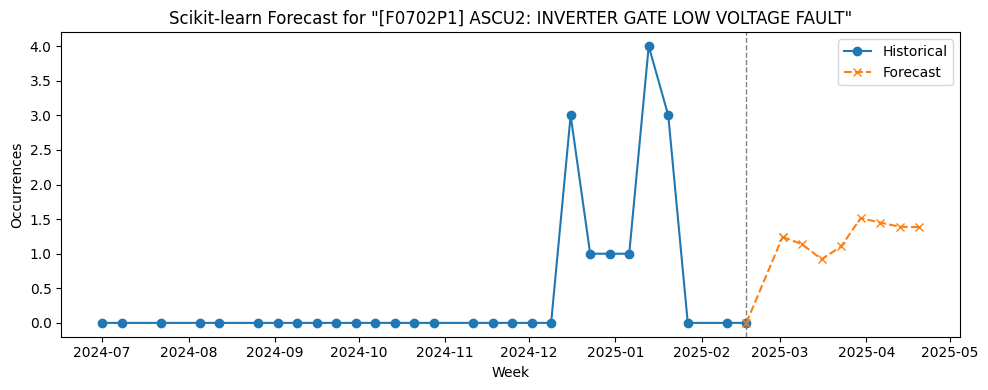

MAE (last 4 weeks) for "[F0702P1] ASCU2: INVERTER GATE LOW VOLTAGE FAULT": 0.7377276785714286


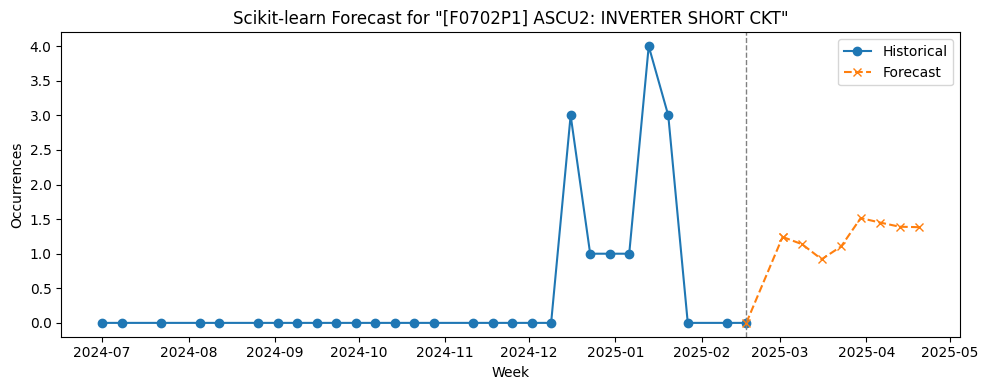

MAE (last 4 weeks) for "[F0702P1] ASCU2: INVERTER SHORT CKT": 0.7377276785714286


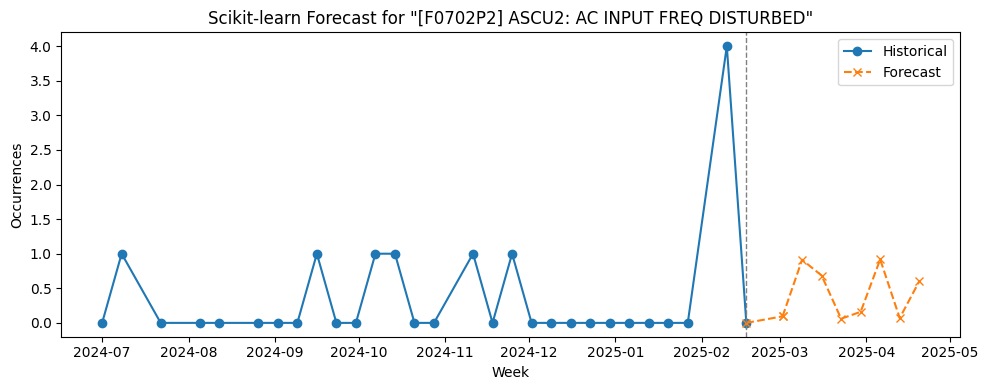

MAE (last 4 weeks) for "[F0702P2] ASCU2: AC INPUT FREQ DISTURBED": 1.2394779040404038


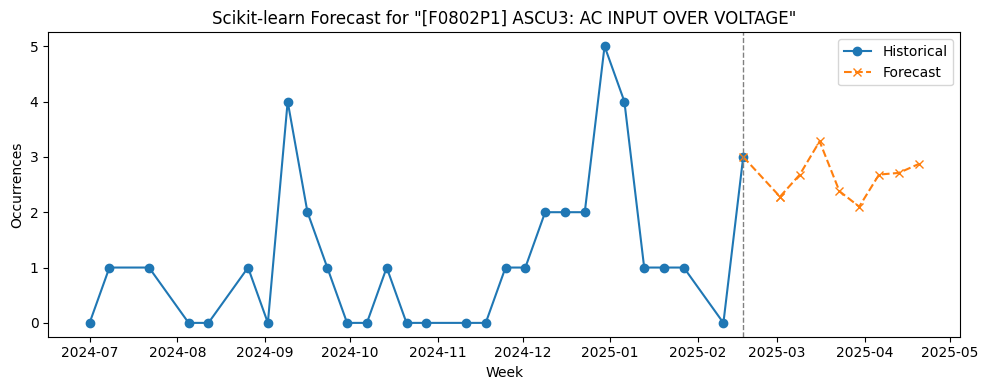

MAE (last 4 weeks) for "[F0802P1] ASCU3: AC INPUT OVER VOLTAGE": 0.3975000000000001


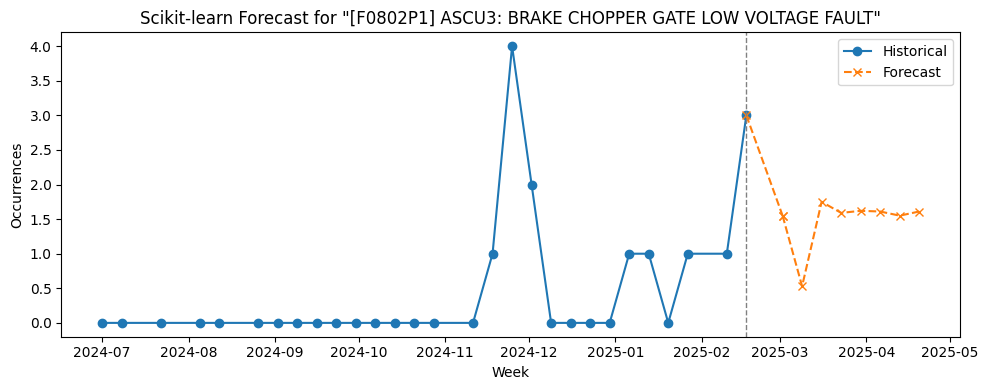

MAE (last 4 weeks) for "[F0802P1] ASCU3: BRAKE CHOPPER GATE LOW VOLTAGE FAULT": 0.5841555368650957


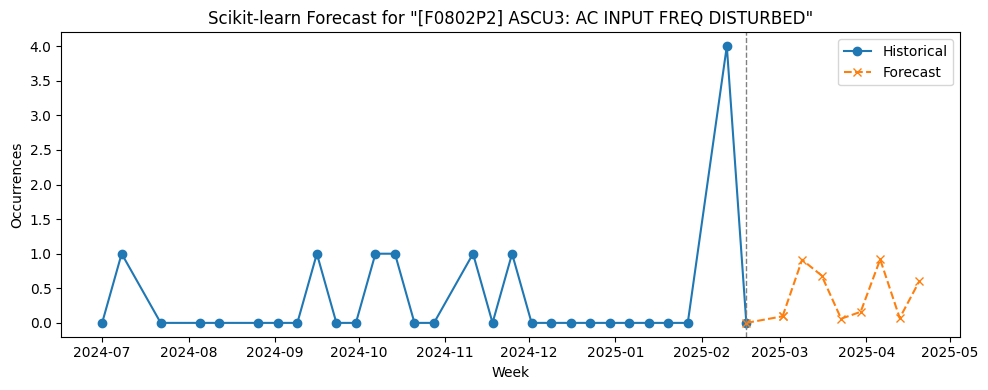

MAE (last 4 weeks) for "[F0802P2] ASCU3: AC INPUT FREQ DISTURBED": 1.2394779040404038


In [63]:
# Forecasting using scikit-learn's RandomForestRegressor for each top 10 fault

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

window = 6  # Number of weeks to use for prediction
forecast_horizon = 8  # Number of weeks to forecast

for fault in top10.columns:
    y = top10[fault].values
    X, y_target = [], []
    for i in range(len(y) - window):
        X.append(y[i : i + window])
        y_target.append(y[i + window])
    X, y_target = np.array(X), np.array(y_target)
    if len(X) == 0:
        continue  # Not enough data

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y_target)

    # Forecast future
    last_window = y[-window:]
    preds = []
    window_vals = last_window.copy()
    for _ in range(forecast_horizon):
        pred = model.predict(window_vals.reshape(1, -1))[0]
        preds.append(pred)
        window_vals = np.roll(window_vals, -1)
        window_vals[-1] = pred

    # Prepare plot
    plt.figure(figsize=(10, 4))
    # Plot historical data
    plt.plot(top10.index, y, marker="o", label="Historical", color="tab:blue")
    # Prepare forecast index
    forecast_index = pd.date_range(top10.index[-1], periods=forecast_horizon+1, freq="W")[1:]
    # Connect last historical point to first forecast point
    plt.plot(
        [top10.index[-1], forecast_index[0]],
        [y[-1], preds[0]],
        color="tab:orange",
        linestyle="--",
        marker="x"
    )
    # Plot forecasted data (connected)
    plt.plot(forecast_index, preds, marker="x", linestyle="--", color="tab:orange", label="Forecast")
    # Draw a horizontal dashed line at the transition
    plt.axvline(x=top10.index[-1], color="gray", linestyle="dashed", linewidth=1)
    plt.title(f'Scikit-learn Forecast for "{fault}"')
    plt.xlabel("Week")
    plt.ylabel("Occurrences")
    plt.legend()
    plt.tight_layout() 
    plt.show()

    # Optionally print MAE on last 4 points
    if len(y_target) > 4:
        y_pred = model.predict(X[-4:])
        print(f'MAE (last 4 weeks) for "{fault}":', mean_absolute_error(y_target[-4:], y_pred))

# 3.3 Forecasting using Statsmodels

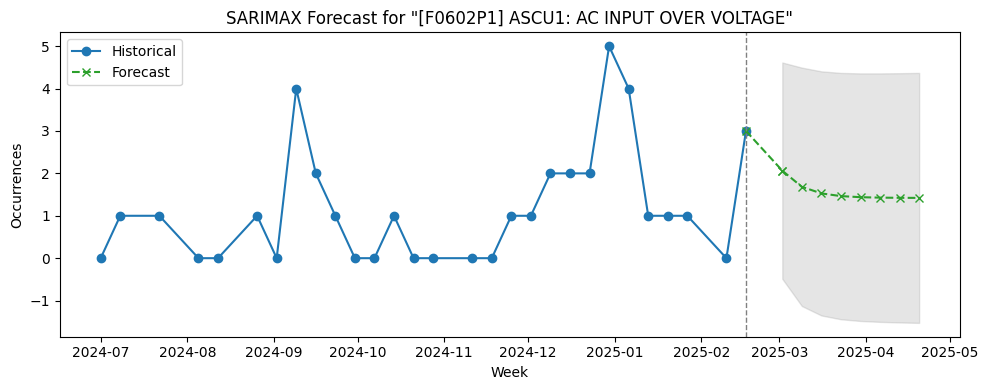

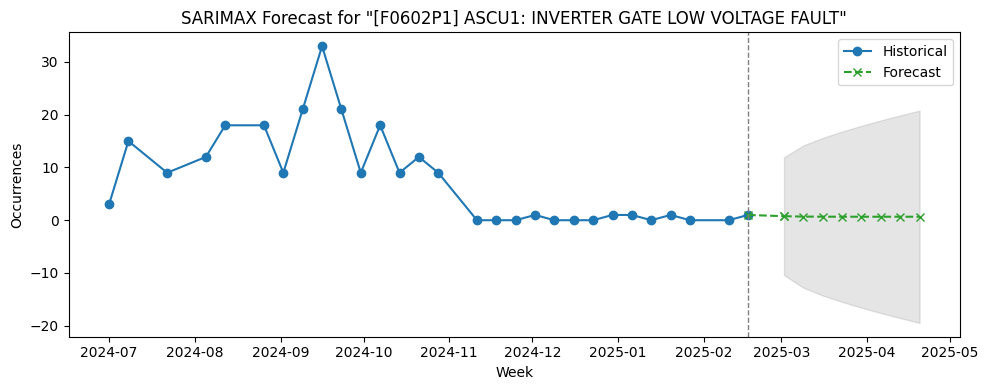

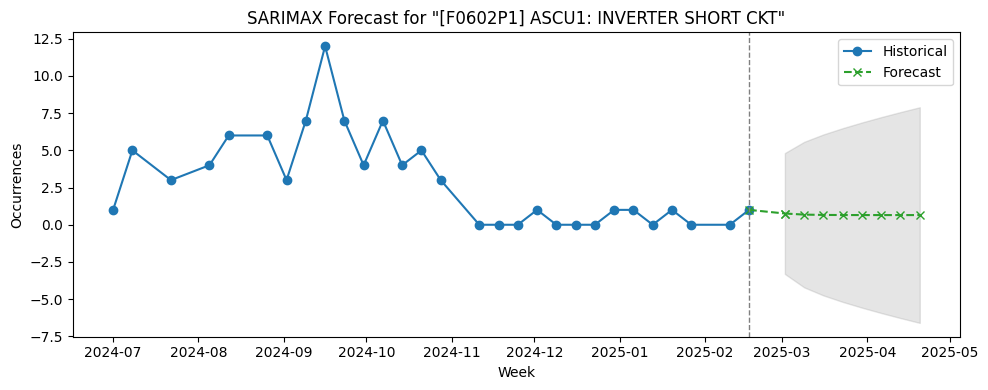

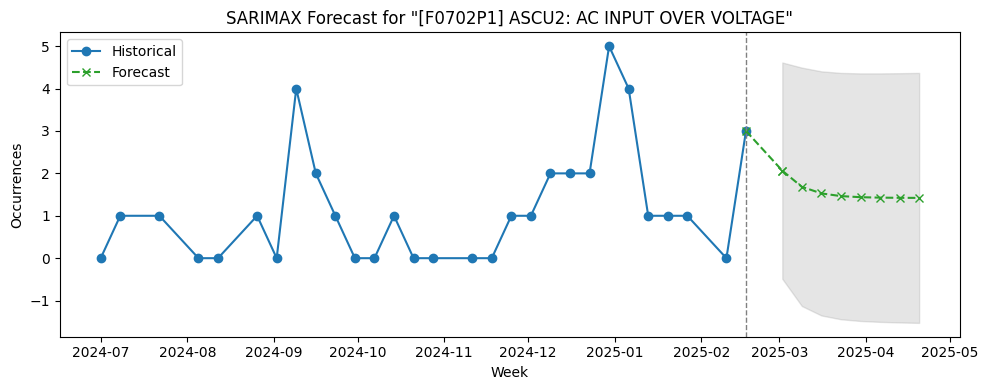

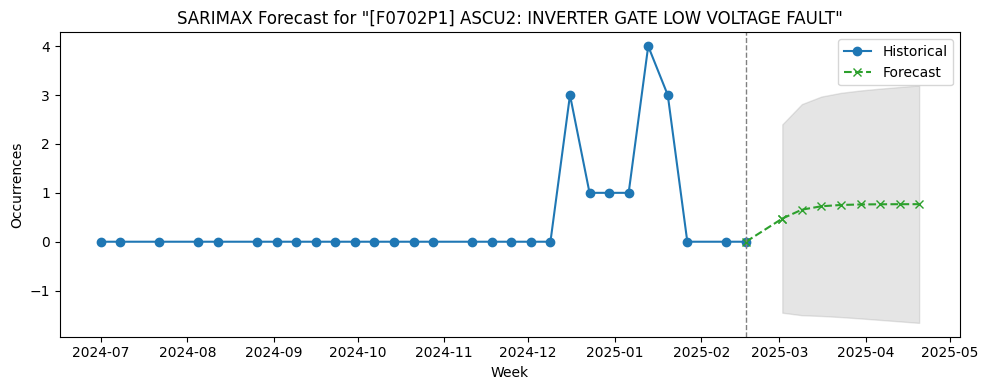

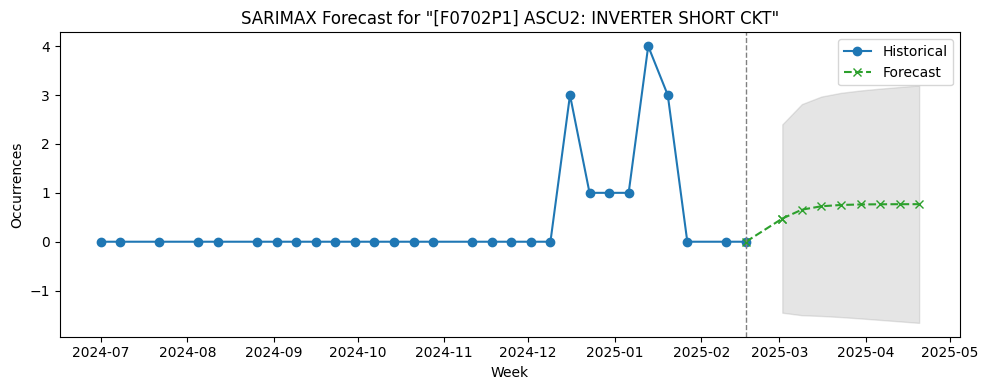

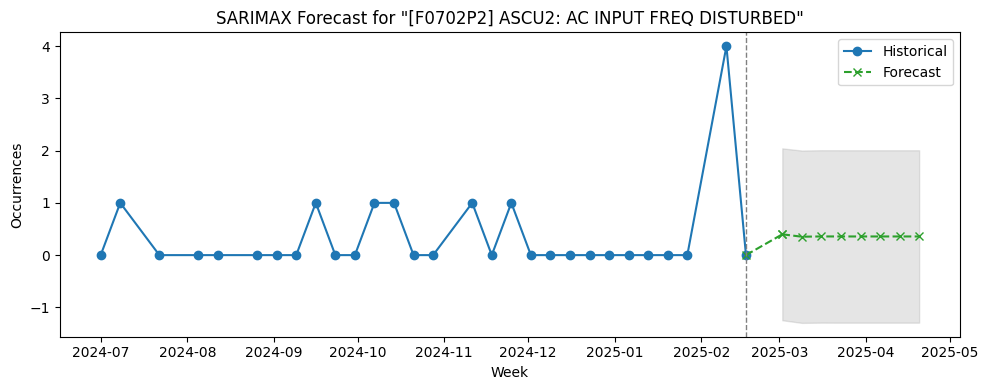

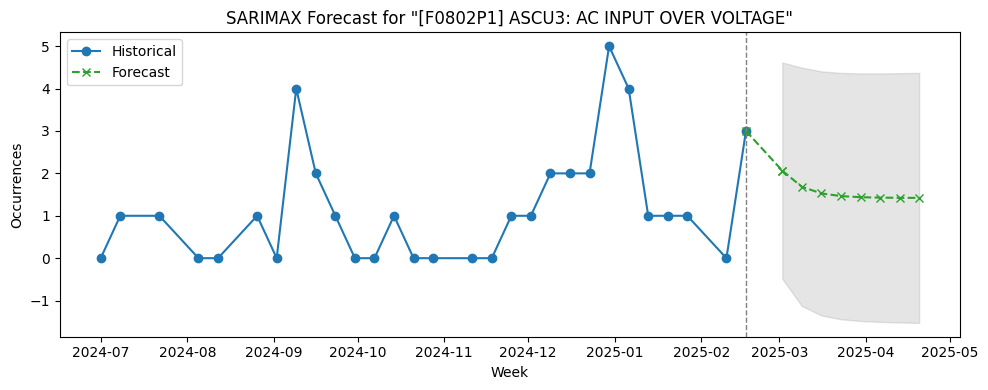

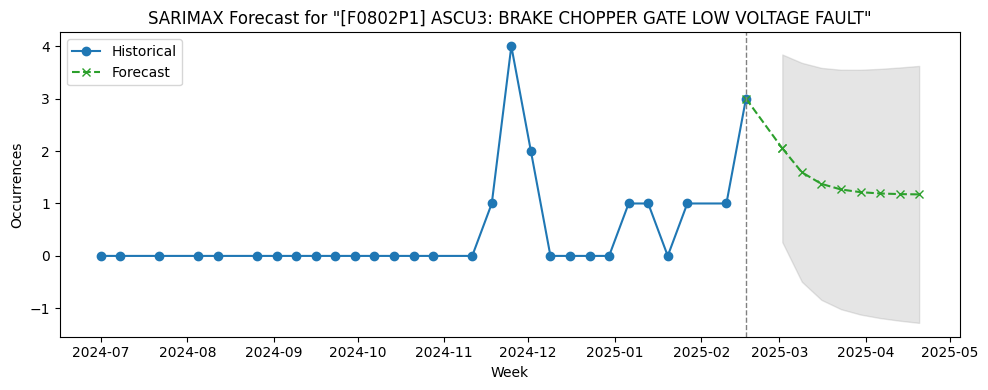

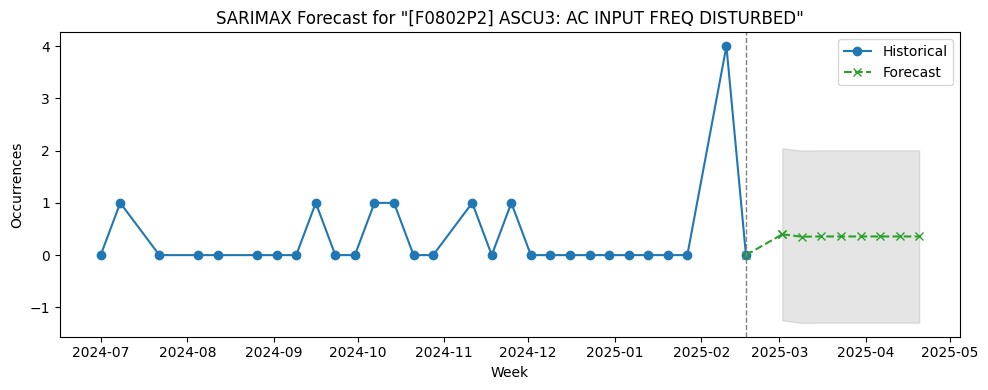

In [64]:
# Forecasting using statsmodels SARIMAX for each top 10 fault

from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

forecast_horizon = 8

for fault in top10.columns:
    y = top10[fault].values
    index = top10.index

    try:
        model = SARIMAX(y, order=(1,1,1), seasonal_order=(0,0,0,0), enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)
        forecast = results.get_forecast(steps=forecast_horizon)
        pred_mean = forecast.predicted_mean
        pred_ci = forecast.conf_int()

        forecast_index = pd.date_range(index[-1], periods=forecast_horizon+1, freq="W")[1:]

        plt.figure(figsize=(10, 4))
        plt.plot(index, y, marker="o", label="Historical", color="tab:blue")
        # Connect last historical point to first forecast point
        plt.plot([index[-1], forecast_index[0]], [y[-1], pred_mean[0]], color="tab:green", linestyle="--", marker="x")
        plt.plot(forecast_index, pred_mean, marker="x", linestyle="--", color="tab:green", label="Forecast")
        plt.fill_between(forecast_index, pred_ci[:, 0], pred_ci[:, 1], color="gray", alpha=0.2)
        plt.axvline(x=index[-1], color="gray", linestyle="dashed", linewidth=1)
        plt.title(f'SARIMAX Forecast for "{fault}"')
        plt.xlabel("Week")
        plt.ylabel("Occurrences")
        plt.legend()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not fit SARIMAX for '{fault}': {e}")

# 3.4 Forecasting using Exponential Smoothing (Holt-Winters)

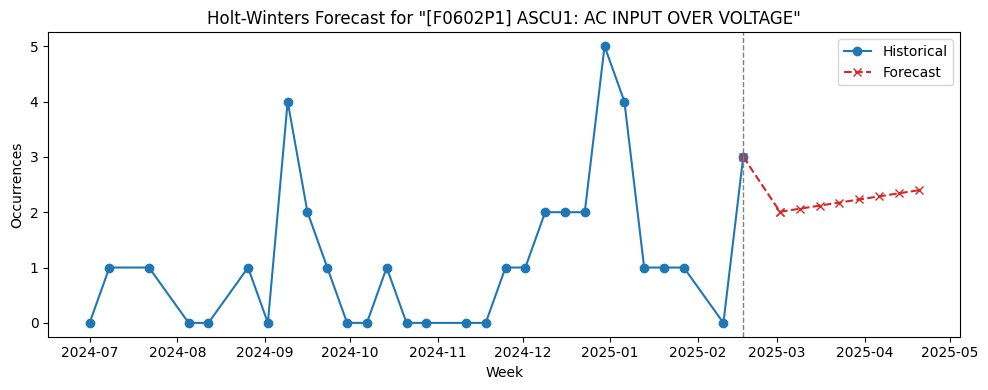

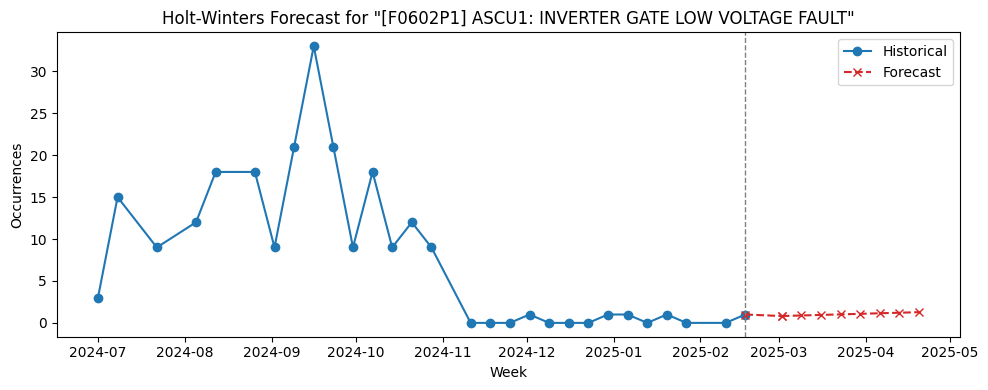

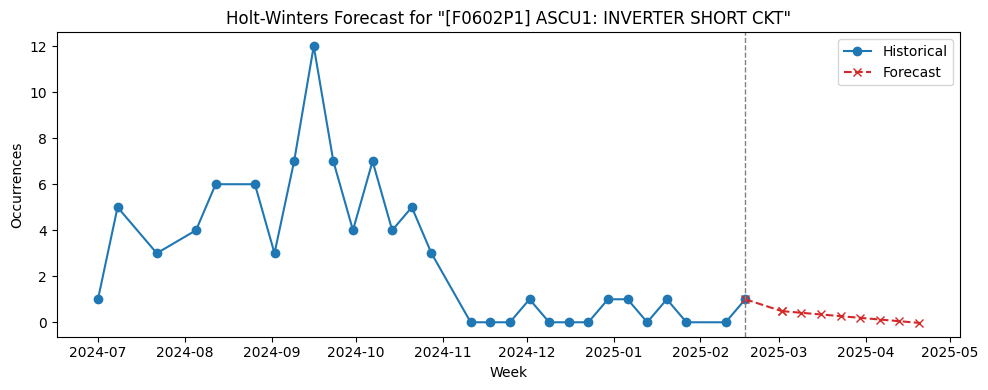

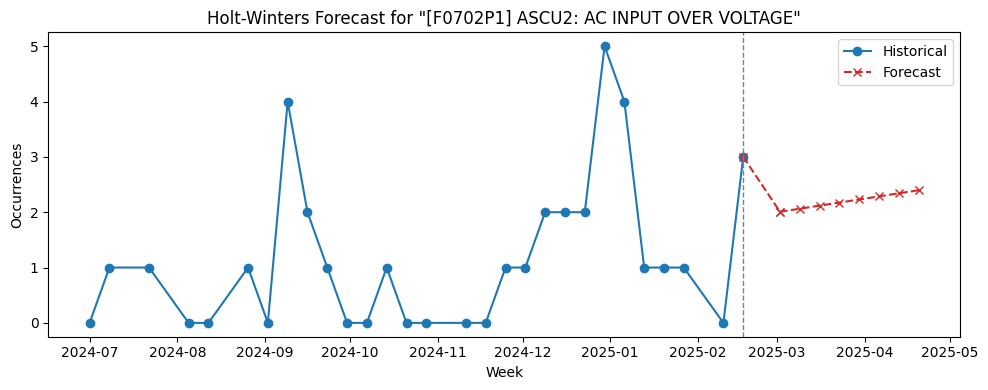

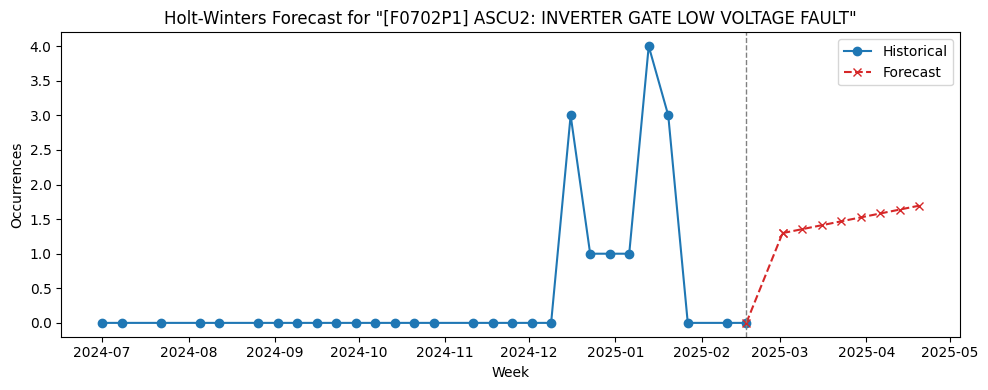

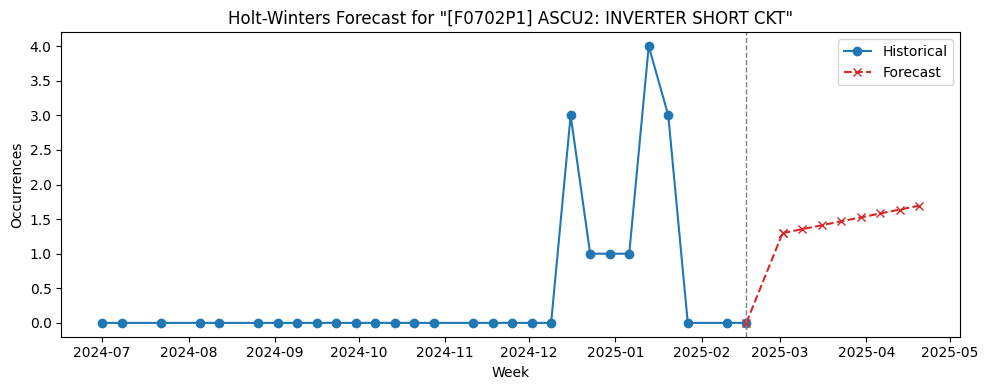

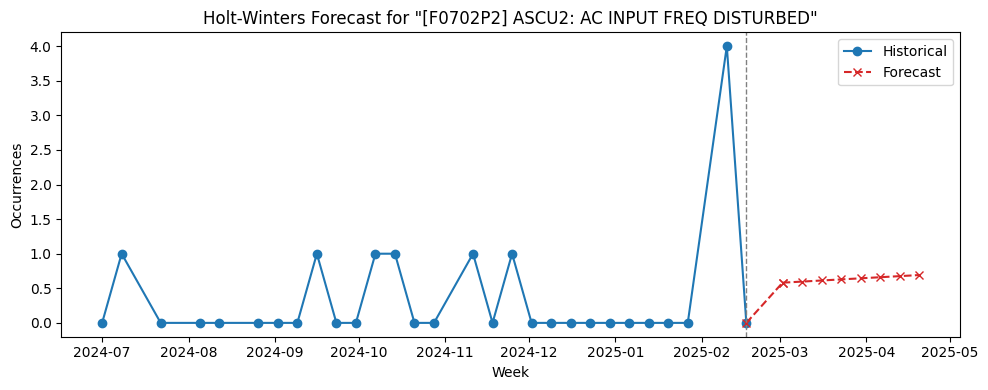

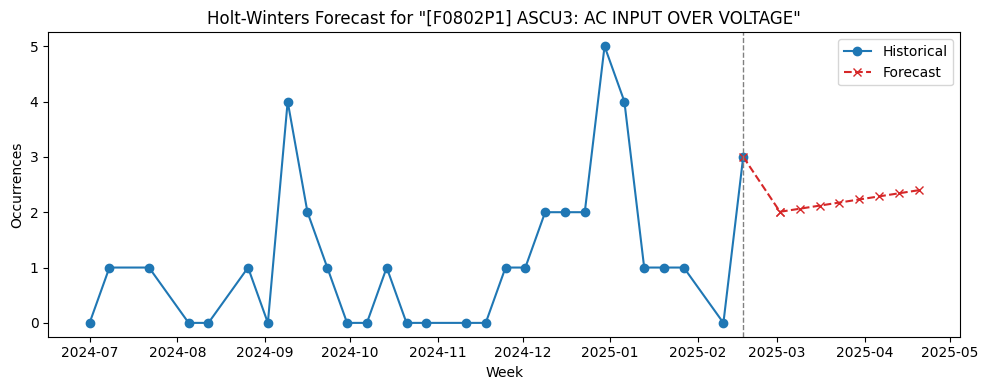

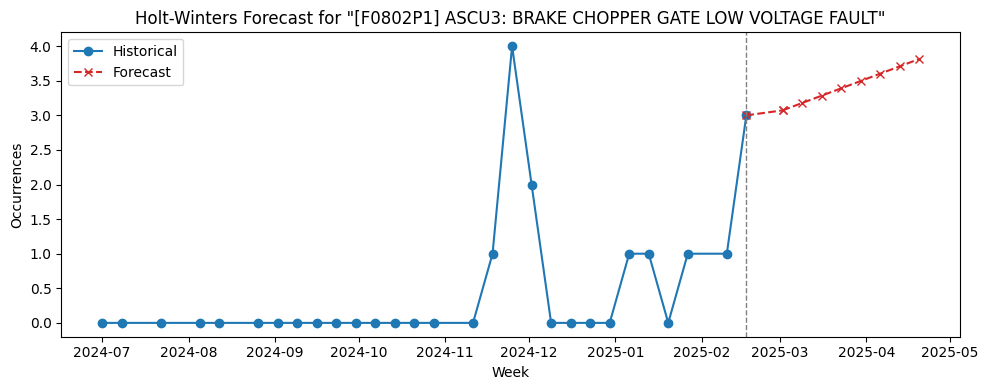

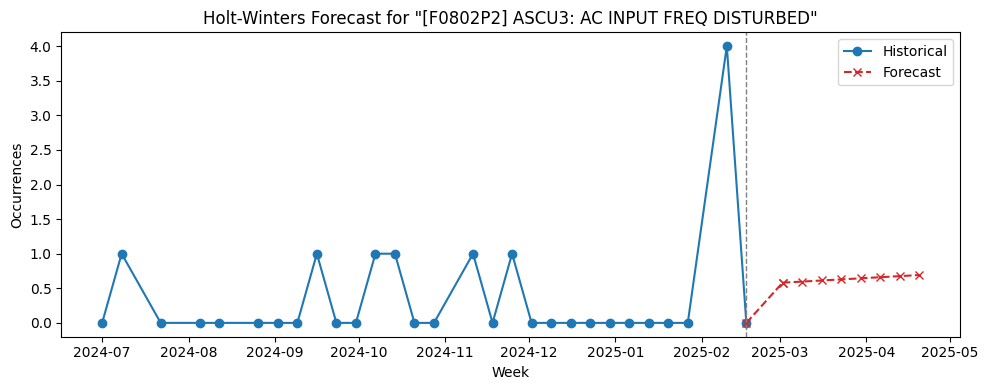

In [65]:
# Forecasting using Exponential Smoothing (Holt-Winters) for each top 10 fault

from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

forecast_horizon = 8

for fault in top10.columns:
    y = top10[fault].values
    index = top10.index

    try:
        model = ExponentialSmoothing(y, trend="add", seasonal=None, initialization_method="estimated")
        fit = model.fit()
        pred_mean = fit.forecast(forecast_horizon)

        forecast_index = pd.date_range(index[-1], periods=forecast_horizon+1, freq="W")[1:]

        plt.figure(figsize=(10, 4))
        plt.plot(index, y, marker="o", label="Historical", color="tab:blue")
        # Connect last historical point to first forecast point
        plt.plot([index[-1], forecast_index[0]], [y[-1], pred_mean[0]], color="tab:red", linestyle="--", marker="x")
        plt.plot(forecast_index, pred_mean, marker="x", linestyle="--", color="tab:red", label="Forecast")
        plt.axvline(x=index[-1], color="gray", linestyle="dashed", linewidth=1)
        plt.title(f'Holt-Winters Forecast for "{fault}"')
        plt.xlabel("Week")
        plt.ylabel("Occurrences")
        plt.legend()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not fit Holt-Winters for '{fault}': {e}")